In [ ]:
#IMPORT LIBRARIES


In [ ]:
!pip install --quiet xgboost shap imbalanced-learn

import os
import joblib
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9,5)

In [ ]:
# LOAD DATA

csv_name = "Churn_Modelling.csv"
if os.path.exists(csv_name):
    df = pd.read_csv(csv_name)
    print("Loaded dataset from local file.")
else:
    url = "https://raw.githubusercontent.com/krishnaik06/Customer-Churn-Modeling/master/Churn_Modelling.csv"
    df = pd.read_csv(url)
    print("Downloaded dataset from fallback URL.")

print("Shape:", df.shape)
df.head()


Loaded dataset from local file.
Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


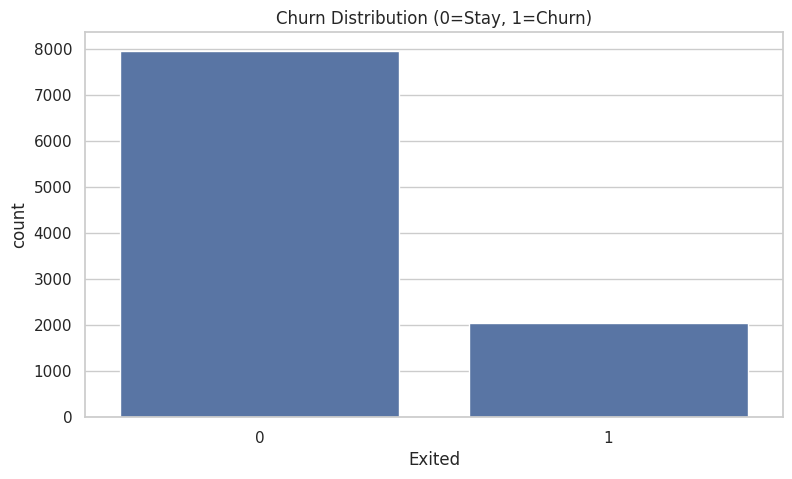

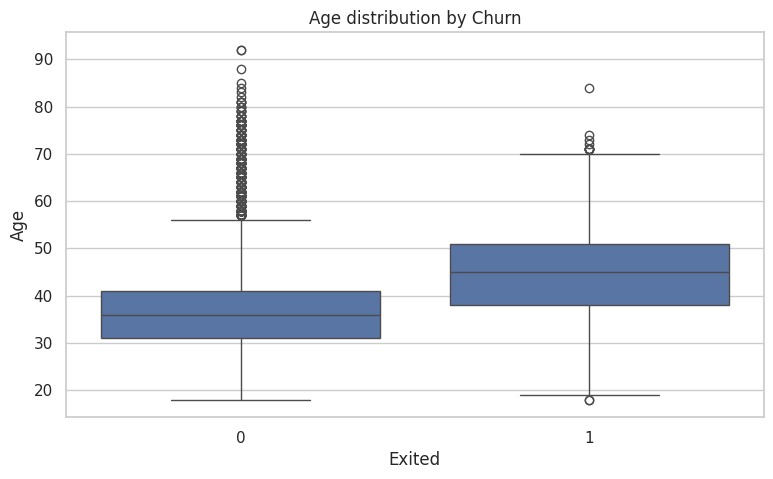

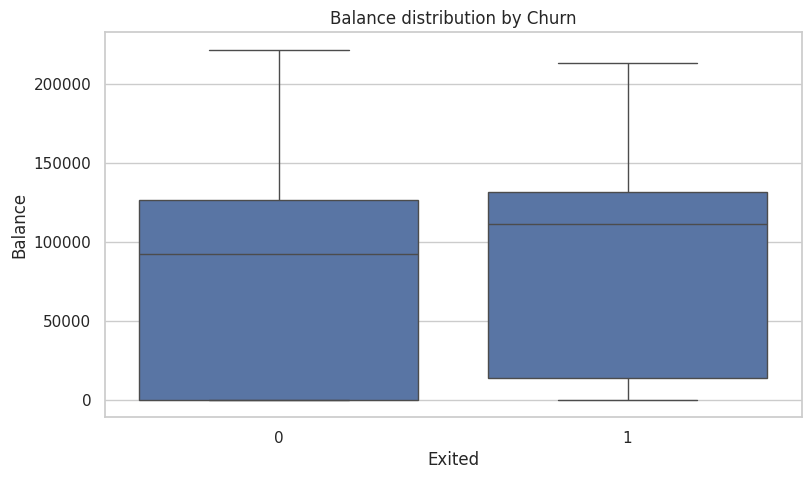

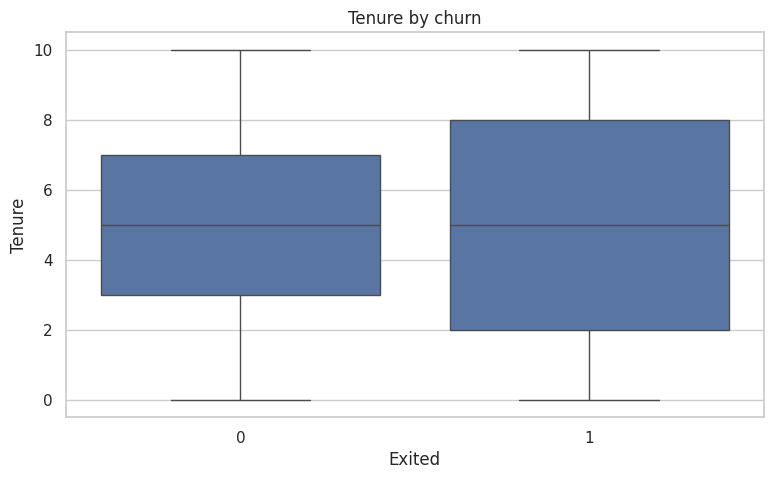

In [ ]:
#EDA - CHURN DISTRIBUTION

sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution (0=Stay, 1=Churn)')
plt.show()

sns.boxplot(x='Exited', y='Age', data=df)
plt.title('Age distribution by Churn')
plt.show()

sns.boxplot(x='Exited', y='Balance', data=df.sample(n=min(2000, len(df)), random_state=1))
plt.title('Balance distribution by Churn')
plt.show()

sns.boxplot(x='Exited', y='Tenure', data=df)
plt.title('Tenure by churn')
plt.show()

In [ ]:
#DATA PREPROCESSING

df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_enc = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

X = df_enc.drop('Exited', axis=1)
y = df_enc['Exited']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Scaling (for LR only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#MODEL TRAINING

log = LogisticRegression(max_iter=2000, random_state=42)
log.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#MODEL EVALUATION FUNCTION

def print_metrics(y_true, y_pred, y_proba=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# Logistic Regression
print("Logistic Regression performance:")
y_pred_log = log.predict(X_test_scaled)
y_proba_log = log.predict_proba(X_test_scaled)[:,1]
print_metrics(y_test, y_pred_log, y_proba_log)

# Random Forest
print("Random Forest performance:")
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
print_metrics(y_test, y_pred_rf, y_proba_rf)

# XGBoost
print("XGBoost performance:")
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
print_metrics(y_test, y_pred_xgb, y_proba_xgb)

Logistic Regression performance:
Accuracy: 0.8005
Precision: 0.5127388535031847
Recall: 0.3955773955773956
F1: 0.44660194174757284
ROC AUC: 0.7595978104452682

Confusion Matrix:
 [[1440  153]
 [ 246  161]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1593
           1       0.51      0.40      0.45       407

    accuracy                           0.80      2000
   macro avg       0.68      0.65      0.66      2000
weighted avg       0.78      0.80      0.79      2000

Random Forest performance:
Accuracy: 0.8455
Precision: 0.6416184971098265
Recall: 0.5454545454545454
F1: 0.5896414342629482
ROC AUC: 0.8504683419937658

Confusion Matrix:
 [[1469  124]
 [ 185  222]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.64      0.55      0.59       407

    accuracy                           0.85      2000


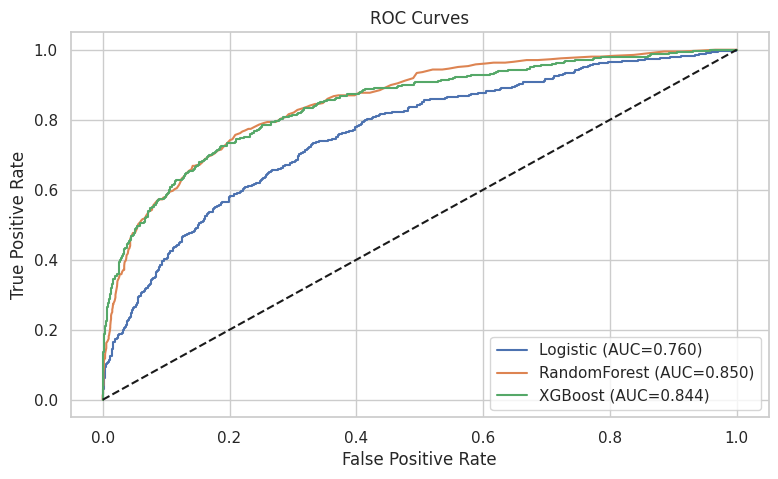

In [ ]:
#ROC CURVES

fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={auc(fpr_log,tpr_log):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc(fpr_rf,tpr_rf):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc(fpr_xgb,tpr_xgb):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

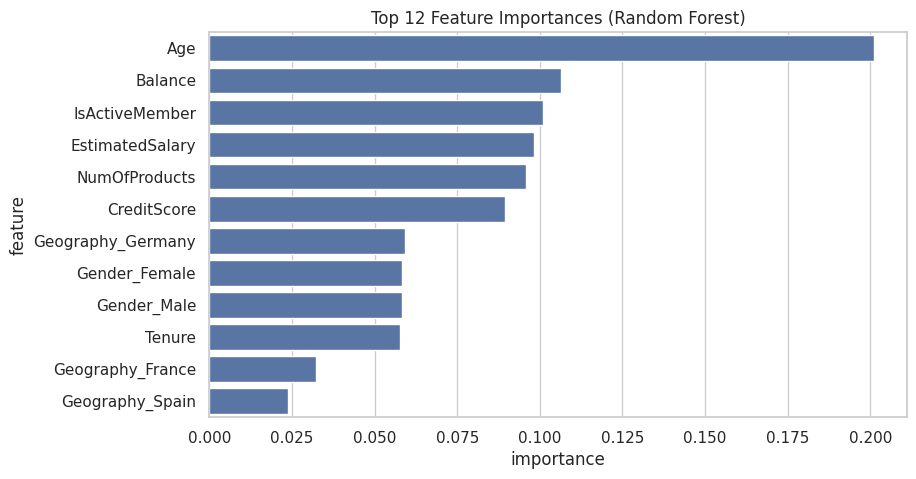

In [ ]:
#FEATURE IMPORTANCE

imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=imp_df.head(12))
plt.title('Top 12 Feature Importances (Random Forest)')
plt.show()

In [ ]:
actions_map = {
    "Tenure": "Welcome rewards & onboarding calls.",
    "IsActiveMember": "Personalized engagement campaigns.",
    "Balance": "Assign relationship managers.",
    "Age": "Targeted retention offers for high-churn age groups.",
    "EstimatedSalary": "Tailored financial planning sessions.",
    "NumOfProducts": "Cross-sell additional relevant products."
}

top_features = imp_df.head(5)['feature']

print("Top churn drivers based on model insights:")
print(imp_df.head(5))

print("\nActions:")
for feature in top_features:
    if feature in actions_map:
        print(f"- {feature} → {actions_map[feature]}")


Top churn drivers based on model insights:
           feature  importance
1              Age    0.201039
3          Balance    0.106379
6   IsActiveMember    0.100995
7  EstimatedSalary    0.098175
4    NumOfProducts    0.095871

Actions:
- Age → Targeted retention offers for high-churn age groups.
- Balance → Assign relationship managers.
- IsActiveMember → Personalized engagement campaigns.
- EstimatedSalary → Tailored financial planning sessions.
- NumOfProducts → Cross-sell additional relevant products.


In [ ]:
#IMPACT SIMULATION
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
actual_churners = tp + fn
predicted_churners = tp
predicted_reduction = predicted_churners / actual_churners

avg_customer_value = 5000
total_churners = df[df['Exited'] == 1].sum()
savings = total_churners * predicted_reduction * avg_customer_value

print(f"Potential annual savings: ${savings:,.0f}")

Potential annual savings: $5,555,455


In [ ]:
#Save model
joblib.dump(rf, "final_churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X.columns), "feature_names.pkl")
print("Saved final_churn_model.pkl, scaler.pkl, feature_names.pkl")

Saved final_churn_model.pkl, scaler.pkl, feature_names.pkl
